Define a new acquisition function
\begin{align*}
\text{ESLB}(x,\eta) &= \mathbb{E}_{p(y^*,y_x\vert \mathcal{D}_t)}\bigg[\log\bigg(\eta_0\exp (-y^*+\max\{y_x,y^*_t\})\mathbb{1}_{y^*>\max\{y_x,y^*_t\}}+\sum_{k=1}^K\eta_k\exp( - y^* + h_{\beta_k}(\mathcal{D}_t,y_x))\mathbb{1}_{y^*>h_{\beta_k}(\mathcal{D}_t,y_x)}\bigg)\bigg],
\end{align*}
where function $h_{\beta_k}$ has the following form
$$h_\beta(D_t, y_x) = \text{mean}(D_t, y_x) + \beta\cdot\text{std}(D_t, y_x).$$

Previously we use $\mu^*(\mathcal{D}_t,y_x)$, which denotes the posterior mean conditioned on $D_t\cup(x,y_x)$, inspired from KG. 
However, computing $\mu^*(\mathcal{D}_t,y_x)$ for every sample $y_x$ is unreasonably expensive since we need to conduct an optimization (to find optimal posterior mean) for every single $y_x$ sample. 
Considering the benefit of VES is the computational convenience (compare to ES/MES), we should implement a cheaper way to estimate MES result. 

In [1]:
from __future__ import annotations
from scipy.optimize import minimize, LinearConstraint
import numpy as np
from torch import nn
from typing import Any, Callable, Optional, Tuple
from torch import Tensor,norm
from botorch.acquisition import ExpectedImprovement,UpperConfidenceBound,qKnowledgeGradient
import torch
from botorch.models.model import Model
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.utils.transforms import (
    concatenate_pending_points,
    t_batch_mode_transform,
)

In [2]:
from botorch.sampling.pathwise import draw_matheron_paths
from botorch.sampling import SobolEngine
num_optima = 100


def optimize_posterior_samples(
    paths,
    x: Tensor,
    bounds: Tensor,
    maximize: Optional[bool] = True,
    candidates: Optional[Tensor] = None,
    raw_samples: Optional[int] = 2048,
    num_restarts: Optional[int] = 10,
    maxiter: int = 100,
    spray_points: int = 20,
    lr: float = 2.5e-4
) -> Tuple[Tensor, Tensor]:
    r"""Cheaply optimizes posterior samples by random querying followed by vanilla
    gradient descent on the best num_restarts points.

    Args:
        paths: Tample paths from the GP which can be called via forward()
        x: evaluation position for y_x
        bounds: The bounds on the search space.
        maximize: Whether or not to maximize or minimize the posterior samples.
        candidates: A priori good candidates (typically previous design points)
            which acts as extra initial guesses for the optimization routine.
        raw_samples: The number of samples with which to query the samples initially.
        num_restarts The number of gradient descent steps to use on each of the best 
        found initial points.
        maxiter: The maximal permitted number of gradient descent steps.
        lr: The stepsize of the gradient descent steps.

    Returns:Optional
        Tuple[Tensor, Tensor]: The optimal input-output pair(s) (X^*. f^*)
    """
    candidate_set = SobolEngine(
        dimension=bounds.shape[0], scramble=True).draw(raw_samples)
    # TODO add spray points
    # queries all samples on all candidates - output raw_samples * num_objectives * num_optima
    candidate_queries = paths.forward(candidate_set)
    num_optima = candidate_queries.shape[0]
    batch_size = candidate_queries.shape[1] if candidate_queries.ndim == 3 else 1 
    argtop_candidates = candidate_queries.argsort(dim=-1, descending=True)[
        ..., 0:num_restarts]
    
    # These are used as masks when retrieving the argmaxes
    row_indexer = torch.arange(num_optima * batch_size).to(torch.long)
    X_argtop = candidate_set[argtop_candidates, :].requires_grad_(requires_grad=True)
    for i in range(maxiter):
        per_sample_outputs = paths.forward(X_argtop)
        grads = torch.autograd.grad(
            per_sample_outputs, X_argtop, grad_outputs=torch.ones_like(per_sample_outputs))[0]
        X_argtop = torch.clamp(X_argtop + lr * grads, 0, 1)  # TODO fix bounds here
    
    per_sample_outputs = paths.forward(X_argtop).reshape(num_optima * batch_size, num_restarts)
    sample_argmax = torch.max(per_sample_outputs, dim=-1, keepdims=True)[1].flatten()
    X_argtop_flat = X_argtop.reshape(num_optima * batch_size, num_restarts, -1)
    
    X_max = X_argtop_flat[row_indexer, sample_argmax].reshape(num_optima, batch_size, -1)
    f_max = per_sample_outputs.max(axis=-1).values.reshape(num_optima, batch_size, 1)
    
    return paths.forward(x.unsqueeze(0)), f_max.detach()

In [34]:
def digamma(x):
    "Faster digamma function assumes x > 0."
    r = 0
    while (x<=5):
        r -= 1/x
        x += 1
    f = 1/(x*x)
    t = f*(-1/12.0 + f*(1/120.0 + f*(-1/252.0 + f*(1/240.0 + f*(-1/132.0
        + f*(691/32760.0 + f*(-1/12.0 + f*3617/8160.0)))))))
    return r + np.log(x) - 0.5/x + t

In [35]:
from scipy.optimize import root
class VariationalEntropySearch(AcquisitionFunction):
    def __init__(
        self,
        model: Model,
        X_init: Tensor,
        bounds: Tensor,
        D_t: Tensor,
        num_EM_iter: Optional[int] = 16
    ) -> None:
        super().__init__(model=model)
        self.model = model
        self.bounds = bounds
        self.D_t = D_t # D_t is a tensor of y values
        self.y_star_t = D_t.max()
        self.k = None
        self.beta = None
        self.x = nn.Parameter(X_init, requires_grad=True)
        
    def forward(self,EM_iter_num=64):
        for _ in range(EM_iter_num):
            self.expectation_step()
            print('Finish E iteration ',_)
            print(self.k, self.beta)
            old_x = self.x.detach()
            self.maximization_step()
            if torch.norm(self.x.detach() - old_x) < 1e-8:
                break
            print('Finish EM iteration ',_)
            print(self.x.detach().numpy())

    def sample(self, N: int): # it computes N samples from current posterior and returns two vector tensors: y_star and y_x based on given x
        r"""Return a tuple of tensors containing joint samples y_star and y_x.

            Args:
                N: number of path samples

            Returns:
                Tensor: A `N` tensor y_star and a `N` tensor y_x
            """

        paths = draw_matheron_paths(self.model, sample_shape=torch.Size([N]))
        y_x, y_star = optimize_posterior_samples(paths, self.x, bounds=self.bounds) 

        return y_star.squeeze(), y_x.squeeze()
    
    def gen_yStar_max(self, N=1000):
        """
        Generate N y_start minus max y_x D_t values
        """
        y_star, y_x = self.sample(N)
        return torch.max(y_star, torch.max(y_x, self.y_star_t))
            
    def expectation_step(self, N=1000): # update eta to maximize eslb
        r"""The expectation step updates values of etas by solving a convex(?) constrained optimization

            Args:
                N: the number of y_x, y_star samples for estimating the expectation

            Returns:
                eta: updated eta
            """
        y_star_max = self.gen_yStar_max(N)
        exp_log_term = torch.log(y_star_max.detach().mean()).item()
        log_exp_term = torch.mean(y_star_max.detach().log()).item()

        root_func = lambda eta: np.log(eta) - digamma(eta) + exp_log_term - log_exp_term

        self.k = root(root_func, 1.0, method='hybr').x[0]
        self.beta = self.k / y_star_max.detach().mean().item()
            
    def maximization_step(self, epochs=50, batch_size=16, return_losses=False): # optimizing x should apply re-parameterization trick
        r"""The maximization step updates x using backpropagation based on current eta
            Args:
                epochs: iteration number for the optimization
                batch_size: size of y_x, y_star for each epoch
                return_loss: return loss if True

            Returns:
                x: updated x
            """
        opt = torch.optim.Adam(self.parameters(), lr=1e-3, betas= (0.9, 0.99))
        losses = []
        for _ in range(epochs):
            opt.zero_grad()
            y_star_max = self.gen_yStar_max(N=batch_size)

            loss = - (self.k - 1)*y_star_max.log().mean() 
            - self.beta * y_star_max.mean()

            loss.backward()
            opt.step()
            losses.append(np.copy(loss.detach().numpy()))
            with torch.no_grad():
                for i in range(len(self.x)):
                    self.x[i].clamp_(self.bounds[0, i], self.bounds[1, i])
        if return_losses:
            return losses
        return

Problem I met so far:


1.   The expectation step does not update eta: eta is fixed to be [1, 0, 0, 0]
2.   NanError: cholesky_cpu: 25 of 25 elements of the torch.Size([5, 5]) tensor are NaN sometimes pops up;





## Experiment

In [25]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

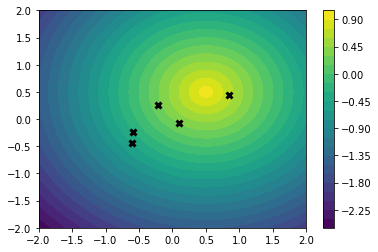

In [26]:
### test VES 
## design training data
train_X = 2*torch.rand(5, 2, dtype=torch.double)-1.0
def f(X,noise=0.0):
    return 1 - (X - 0.5).norm(dim=-1, keepdim=True)
train_Y = f(train_X,noise=0.1)
bounds = torch.stack([torch.zeros(2)-2, 2*torch.ones(2)]).to(torch.double)
num_samples = 128
num_iter = 2

# plot function f
import matplotlib.pyplot as plt
nx,ny = 101,101
X1,X2 = torch.linspace(bounds[0,0],bounds[1,0],nx),torch.linspace(bounds[0,1],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
f_input = torch.vstack((Xx.flatten(),Xy.flatten())).T
Yz = f(f_input).reshape(nx,ny)

plt.contourf(Xx,Xy,Yz,25)
plt.colorbar()
plt.plot(train_X[:,0],train_X[:,1],'kx',mew=3)
plt.show()

In [36]:
gp = SingleTaskGP(train_X, train_Y) # gp model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
fit_gpytorch_mll(mll) # fit mll hyperpara

ei = ExpectedImprovement(gp,best_f=train_Y.max())
kg = qKnowledgeGradient(gp,num_fantasies=128)
ucb = UpperConfidenceBound(gp,beta=1.0)
ves = VariationalEntropySearch(
    model = gp, 
    X_init = Tensor([0.1, 0.1]).type(torch.double), 
    bounds = Tensor([[-2, -2], [2, 2]]).type(torch.double), 
    D_t = train_Y.squeeze())

## optimize acqf
# ei
ei_candidate, _ = optimize_acqf(
  ei, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
ei_x,ei_y = ei_candidate,f(ei_candidate)
print(ei_x,ei_y.item())

# # kg
# kg_candidate, _ =optimize_acqf(
#   kg, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
# )
# kg_x,kg_y = kg_candidate,f(kg_candidate)
# print(kg_x,kg_y.item())

# # ucb
# ucb_candidate, _ =optimize_acqf(
#   ucb, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
# )
# ucb_x,ucb_y = ucb_candidate,f(ucb_candidate)
# print(ucb_x,ucb_y.item())

# ves
print(ves.k, ves.beta)
ves.expectation_step()
print(ves.k,ves.beta)
print(ves.x.detach().numpy())
losses = ves.maximization_step(return_losses=True)
# ves(EM_iter_num=4)
ves_x,ves_y = ves.x,f(ves.x)
print(ves_x,ves_y.item())

/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.5531, 0.4754]], dtype=torch.float64) 0.9414878956871727
None None
40177117.8142145 36897263.42396967
[0.1 0.1]
Parameter containing:
tensor([0.1000, 0.1000], dtype=torch.float64, requires_grad=True) 0.4343145771581044


In [37]:
losses

[array(-3065542.12240937),
 array(966475.83993714),
 array(-2182917.02920521),
 array(-3420470.36378092),
 array(-321320.11849698),
 array(-1027686.34921876),
 array(-2544482.60610384),
 array(-618025.89387914),
 array(-3013455.0784682),
 array(-737309.48625523),
 array(-4493653.07523803),
 array(-4587229.48290766),
 array(-1005731.11710113),
 array(1356914.04935604),
 array(-725518.98265133),
 array(-4219816.81402636),
 array(-3334727.01340421),
 array(-3271619.47901109),
 array(-3922772.57643705),
 array(-2682830.03887467),
 array(-822499.64912358),
 array(-606455.74903003),
 array(-3440546.19904743),
 array(-4712637.11190243),
 array(-682505.49426543),
 array(-3278327.96694938),
 array(-3084152.91794199),
 array(-2628377.21698496),
 array(-2785846.20506256),
 array(711028.99277015),
 array(-1775849.96790264),
 array(-1825888.37298764),
 array(-179343.29449432),
 array(-2402640.78663748),
 array(-5045152.82235462),
 array(2193312.63738857),
 array(1217812.37788818),
 array(-1935016.7

To show the intuition behind, suppose we fix the value of x

Text(0.5, 1.0, '$p(y^*|D)$')

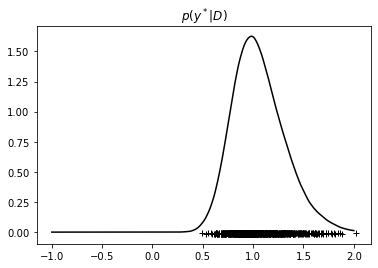

In [28]:
from sklearn.neighbors import KernelDensity
# sample y_star 
N = 1000
y_star, _ = ves.sample(N)
y_star = y_star.detach().numpy()
kde = KernelDensity(kernel="cosine", bandwidth=N**(-0.2)).fit(y_star[:,None])
Y = np.linspace(-1,2,400)[:,None]
y_log_dens = kde.score_samples(Y)

# plot y_star
plt.plot(Y,np.exp(y_log_dens),c='k')#, fc="black", alpha=0.2)
plt.plot(y_star, -0.005 - 0.01 * np.random.random(y_star.shape), "+k")
plt.title(r'$p(y^*|D)$')

In [29]:
new_Dt = ves.D_t
mean = torch.mean(new_Dt)
std = torch.std(new_Dt)
mean + ves.beta_lst * std

AttributeError: 'VariationalEntropySearch' object has no attribute 'beta_lst'

In [ ]:
eta = np.eye(4)[1]
def exp_den(beta_lst, x):
    res = []
    for beta in beta_lst:
        if x < beta:
            res.append(0)
        else:
            res.append(np.exp(-x+beta))
    return np.array(res)
def eslb(eta, best_f, lb, y_star):
    elem = [best_f, *lb]
    return sum([diy_log(np.inner(eta, exp_den(elem, y))) for y in y_star])

def diy_log(l):
    if l <= 0:
        return 0
    else:
        return np.log(l)

lb = mean + ves.beta_lst * std
best_f = max(new_Dt)
print(eslb(eta, best_f, lb, y_star))
print(eta)

-389.8740329990811
[0. 1. 0. 0.]


In [ ]:
K = 4
cnst_eq_A = np.expand_dims(np.ones(K), axis=0) # equality constraint
cnst_ineq_A = np.eye(K) # inequality constraint

def f(eta):
    return -eslb(eta, best_f, lb, y_star)

cnst_eq = LinearConstraint(cnst_eq_A, np.array([1]), np.array([1]))
cnst_ineq = LinearConstraint(cnst_ineq_A, np.zeros(K), np.ones(K))
res = minimize(f, eta, constraints=[cnst_eq, cnst_ineq])
res.x

array([0., 1., 0., 0.])

In [ ]:
[f(np.eye(4)[i]) for i in range(4)]

[405.32301222682605, 389.8740329990811, 139.75264200921205, 22.827619928910472]

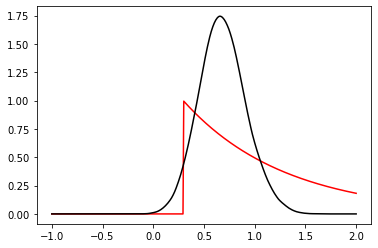

In [ ]:
y_den = [np.inner(eta, exp_den([best_f, *lb], y[0])) for y in Y]
plt.plot(Y,y_den,c='r')
plt.plot(Y,np.exp(y_log_dens),c='k')

## Archived code

In [ ]:
from botorch.sampling.pathwise import draw_matheron_paths
num_optima = 100


def optimize_posterior_samples(
    paths: SamplePath,
    bounds: Tensor,
    maximize: Optional[bool] = True,
    candidates: Optional[Tensor] = None,
    raw_samples: Optional[int] = 2048,
    num_restarts: Optional[int] = 10,
    maxiter: int = 100,
    spray_points: int = 20,
    lr: float = 2.5e-4
) -> Tuple[Tensor, Tensor]:
    r"""Cheaply optimizes posterior samples by random querying followed by vanilla
    gradient descent on the best num_restarts points.

    Args:
        paths: Tample paths from the GP which can be called via forward()
        bounds: The bounds on the search space.
        maximize: Whether or not to maximize or minimize the posterior samples.
        candidates: A priori good candidates (typically previous design points)
            which acts as extra initial guesses for the optimization routine.
        raw_samples: The number of samples with which to query the samples initially.
        num_restarts The number of gradient descent steps to use on each of the best 
        found initial points.
        maxiter: The maximal permitted number of gradient descent steps.
        lr: The stepsize of the gradient descent steps.

    Returns:Optional
        Tuple[Tensor, Tensor]: The optimal input-output pair(s) (X^*. f^*)
    """
    candidate_set = SobolEngine(
        dimension=bounds.shape[0], scramble=True).draw(raw_samples)
    # TODO add spray points
    # queries all samples on all candidates - output raw_samples * num_objectives * num_optima
    candidate_queries = paths.forward(candidate_set)
    num_optima = candidate_queries.shape[0]
    batch_size = candidate_queries.shape[1] if candidate_queries.ndim == 3 else 1 
    argtop_candidates = candidate_queries.argsort(dim=-1, descending=True)[
        ..., 0:num_restarts]
    
    # These are used as masks when retrieving the argmaxes
    row_indexer = torch.arange(num_optima * batch_size).to(torch.long)
    X_argtop = candidate_set[argtop_candidates, :].requires_grad_(requires_grad=True)
    for i in range(maxiter):
        per_sample_outputs = paths.forward(X_argtop)
        grads = torch.autograd.grad(
            per_sample_outputs, X_argtop, grad_outputs=torch.ones_like(per_sample_outputs))[0]
        X_argtop = torch.clamp(X_argtop + lr * grads, 0, 1)  # TODO fix bounds here
    
    per_sample_outputs = paths.forward(X_argtop).reshape(num_optima * batch_size, num_restarts)
    sample_argmax = torch.max(per_sample_outputs, dim=-1, keepdims=True)[1].flatten()
    X_argtop_flat = X_argtop.reshape(num_optima * batch_size, num_restarts, -1)
    
    X_max = X_argtop_flat[row_indexer, sample_argmax].reshape(num_optima, batch_size, -1)
    f_max = per_sample_outputs.max(axis=-1).values.reshape(num_optima, batch_size, 1)
    
    return X_max.detach(), f_max.detach()


paths = draw_matheron_paths(model, sample_shape=torch.Size([num_optima]))

optimal_inputs, optimal_outputs = optimize_posterior_samples(paths, bounds=Tensor(bounds))